# DengAI Analysis Part 01 - Naive Regressors

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Content

In this notebook, we will be training some naive sklearn regressors to predict the number of dengue cases in City SJ and IQ given the set of cleaned features describing the City at the timestep.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import subprocess
import statsmodels.formula.api as sm
from statsmodels import stats as sms
import statsmodels as statsmodels
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir
import warnings
warnings.filterwarnings('ignore')

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

In [2]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="clean_feats"></a>

---
## Cleaned Features

In [3]:
sj_X = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col='week_start_date')
sj_y = pd.read_csv('./data/dengai/cleaned/sj_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')
iq_X = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col='week_start_date')
iq_y = pd.read_csv('./data/dengai/cleaned/iq_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')

__Let's take a look at their respective histograms of the distribution of number of dengue cases for each observation__

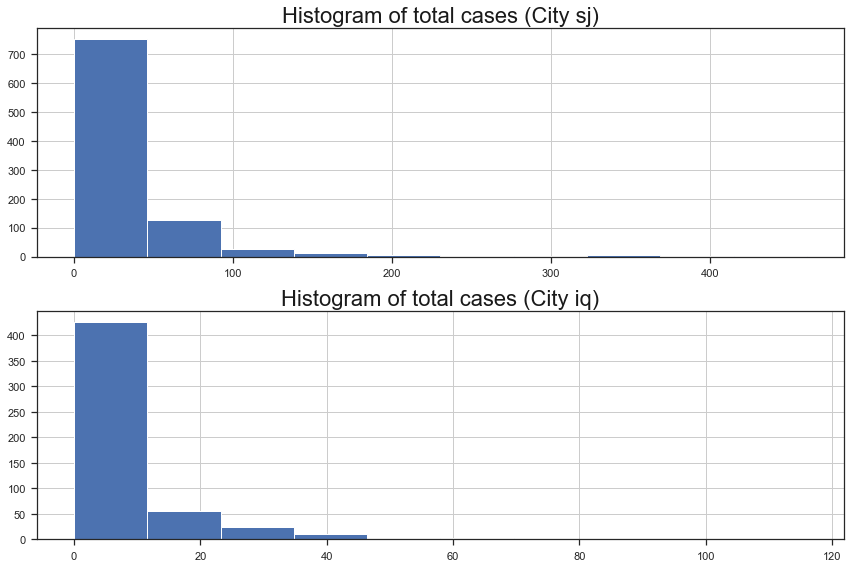

In [4]:
rcParams['figure.figsize'] = 12, 8
fig, ax = plt.subplots(2,1)

ax[0].hist(sj_y['num_cases'])
ax[0].grid(True)
ax[0].set_title("Histogram of total cases (City sj)", fontsize=22, color='k')

ax[1].hist(iq_y['num_cases'])
ax[1].grid(True)
ax[1].set_title("Histogram of total cases (City iq)", fontsize=22, color='k')

plt.tight_layout()
plt.show();

__It appears that the label data for both cities are heavily skewed to the right, we can either do a log transform to correct the skewness, but let's do a Yeo Johnson Transform on the labels to make them normally distributed instead.__

In [5]:
from sklearn.preprocessing import PowerTransformer

# Applying yeo-johnson transform on the labels of City sj 
# REMEMBER TO INVERSE TRANSFORM YOUR Y_PREDS
sj_pwr = PowerTransformer()
sj_y = pd.Series(sj_pwr.fit_transform(sj_y).flatten(), index=sj_y.index)

# Applying yeo-johnson transform on the labels of City iq 
# REMEMBER TO INVERSE TRANSFORM YOUR Y_PREDS
iq_pwr = PowerTransformer()
iq_y = pd.Series(iq_pwr.fit_transform(iq_y).flatten(), index=iq_y.index)

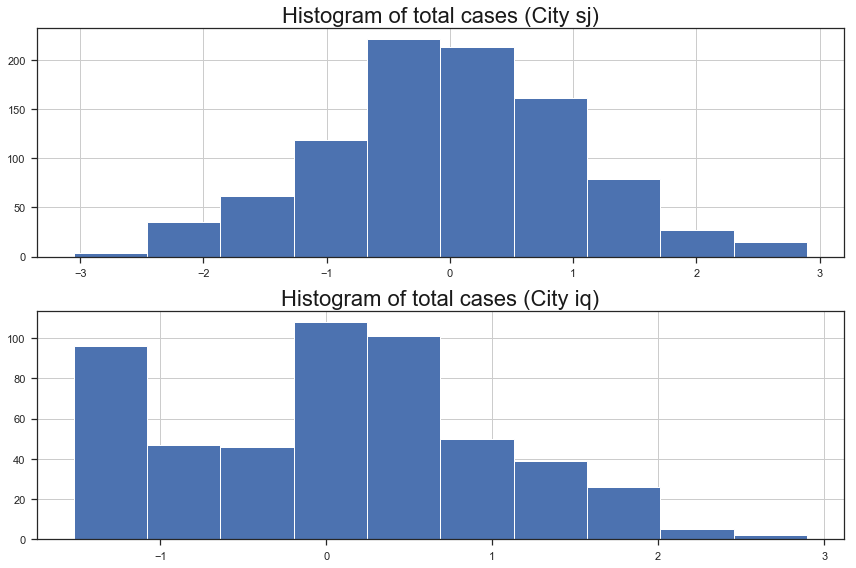

In [6]:
rcParams['figure.figsize'] = 12, 8
fig, ax = plt.subplots(2,1)

ax[0].hist(sj_y)
ax[0].grid(True)
ax[0].set_title("Histogram of total cases (City sj)", fontsize=22, color='k')

ax[1].hist(iq_y)
ax[1].grid(True)
ax[1].set_title("Histogram of total cases (City iq)", fontsize=22, color='k')

plt.tight_layout()
plt.show();

__This does seem better, so we'll save these as their respective X and y data__

<a id="models"></a>

---
## Brute-Force Plug and Chug Models

__Let's just try out a few vanilla regression models on the dataset to see what accuracy we can get__

In [7]:
# Import models and utilities from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from collections import defaultdict
from time import time

# Let's define a function that'll settle the training
# testing pipeline for us
def train(X, y, mods, pwr):
    """
    Handles the entire train and testing pipeline
    
    Parameters:
    -----------
    X: (pandas.DataFrame) Feature columns
    y: (pandas.DataFrame) Labels
    mods: (list) List of sklearn models to be trained on
    pwr: yeo-johnson Transformer that was used to transform y
    
    Returns:
    --------
    DataFrame of results of training and also a dictionary of the trained models
    """
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Initialize models dictionary
    trained_mods = {str(mod())[:str(mod()).find('(')]: mod for mod in mods}
    
    # Initialize model performance dictionary
    performance_mods = {str(mod())[:str(mod()).find('(')]: defaultdict(float) for mod in mods}
    
    # Split into training and testing set
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Split into training and testing sets using KFold cross validation
    kf = KFold(n_splits=20, shuffle=True, random_state=42)
    
    # Loop through all models
    for idx, (mod_name, mod) in enumerate(trained_mods.items()):
        
        # List of each score we get from each fold training / testing
        mse_train_scores = []
        mae_train_scores = []
        r2_train_scores = []
        mse_test_scores = []
        mae_test_scores = []
        r2_test_scores = []
        
        # Go through each fold in the KFold cross validation
        for train_index, test_index in kf.split(X):
            
            # Train Test Splits
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            ################
            ### TRAINING ###
            ################
            # Initialize current model
            curr_mod = mod()

            # Fit the model
            trained_mod = curr_mod.fit(X_train, y_train) 
            
            # Prediction scores for training set
            y_train_pred = pwr.inverse_transform(trained_mod.predict(X_train)[:,None]).astype(int)
            mse_train_scores.append(mean_squared_error(y_train, y_train_pred))
            mae_train_scores.append(mean_absolute_error(y_train, y_train_pred))
            r2_train_scores.append(r2_score(y_train, y_train_pred)) 
        
            ###############
            ### TESTING ###
            ###############
            # Prediction scores for testing set
            y_test_pred = pwr.inverse_transform(trained_mod.predict(X_test)[:,None]).astype(int)
            mse_test_scores.append(mean_squared_error(y_test, y_test_pred))
            mae_test_scores.append(mean_absolute_error(y_test, y_test_pred))
            r2_test_scores.append(r2_score(y_test, y_test_pred)) 
        
        # Saving average train scores
        performance_mods[mod_name]['train_' + str(mean_squared_error.__name__)] = np.mean(mse_train_scores)
        performance_mods[mod_name]['train_' + str(mean_absolute_error.__name__)] = np.mean(mae_train_scores)
        performance_mods[mod_name]['train_' + str(r2_score.__name__)] = np.mean(r2_train_scores)
        
        # Saving average test scores
        performance_mods[mod_name]['test_' + str(mean_squared_error.__name__)] = np.mean(mse_test_scores)
        performance_mods[mod_name]['test_' + str(mean_absolute_error.__name__)] = np.mean(mae_test_scores)
        performance_mods[mod_name]['test_' + str(r2_score.__name__)] = np.mean(r2_test_scores)
        
        # Saving last trained model
        trained_mods[mod_name] = trained_mod
            
    return performance_mods, trained_mods

In [8]:
# Let's declare the list of models we want to train
mods_to_train = [LinearRegression, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, KernelRidge, SVR, MLPRegressor]

In [9]:
# City SJ
sj_performance_mods, sj_trained_mods = train(sj_X, sj_y, mods_to_train, sj_pwr)
pd.DataFrame.from_dict(sj_performance_mods).transpose()

,test_mean_absolute_error,test_mean_squared_error,test_r2_score,train_mean_absolute_error,train_mean_squared_error,train_r2_score
LinearRegression,2.043205e+01,5.389678e+02,-5.870640e+02,20.298067,509.506977,-508.580312
RandomForestRegressor,2.098857e+01,6.211381e+02,-6.535262e+02,25.941328,1583.178531,-1581.663849
AdaBoostRegressor,1.827879e+01,4.025916e+02,-4.305016e+02,18.901262,460.596832,-459.519714
GradientBoostingRegressor,2.100571e+01,6.328762e+02,-6.625640e+02,22.537098,970.400041,-969.059461
KernelRidge,2.017606e+01,5.632345e+02,-6.061345e+02,19.932012,472.861891,-471.932023
SVR,1.904757e+01,3.850466e+02,-4.222260e+02,23.505280,804.388046,-803.541282
MLPRegressor,1.110137e+06,1.158409e+15,-1.179338e+15,28.190120,219037.003101,-216271.696014


In [10]:
# City IQ
iq_performance_mods, iq_trained_mods = train(iq_X, iq_y, mods_to_train, iq_pwr)
pd.DataFrame.from_dict(iq_performance_mods).transpose()

,test_mean_absolute_error,test_mean_squared_error,test_r2_score,train_mean_absolute_error,train_mean_squared_error,train_r2_score
LinearRegression,3.967344,2.234346e+01,-2.540695e+01,3.926131,20.978718,-19.985725
RandomForestRegressor,4.297949,2.886458e+01,-3.185212e+01,5.165688,49.672256,-48.685983
AdaBoostRegressor,3.696273,1.826533e+01,-1.989023e+01,3.732397,18.699550,-17.703832
GradientBoostingRegressor,4.203516,2.552571e+01,-2.867835e+01,4.547065,31.067656,-30.071640
KernelRidge,3.863844,1.936543e+01,-2.156076e+01,3.832212,18.441002,-17.447080
SVR,3.321154,1.242421e+01,-1.256034e+01,4.903239,35.679352,-34.689615
MLPRegressor,4298.982678,9.587027e+09,-9.331794e+09,4.910001,60.115510,-59.133844


__Seems like AdaBoost is performing the best overall, so let's use that on the competition test features and use the AdaBoost predictions as our initial submission. Because we used LinearRegression as well, let's explore whether the Linear Regression Assumptions hold in the next part (OPTIONAL), else skip to Part 4 where we will explore feature selection / engineering in order to boost the performances of these models.__

<a id="test"></a>

---
## Competition Test Prediction

__Here we will use the AdaBoost model in order to predict the labels given the competition's test features__

In [11]:
test_feats_df = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')
test_feats_df.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,sj,2008,18,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2008-05-06,sj,2008,19,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2008-05-13,sj,2008,20,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
2008-05-20,sj,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
2008-05-27,sj,2008,22,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


### Clean Data Pipeline

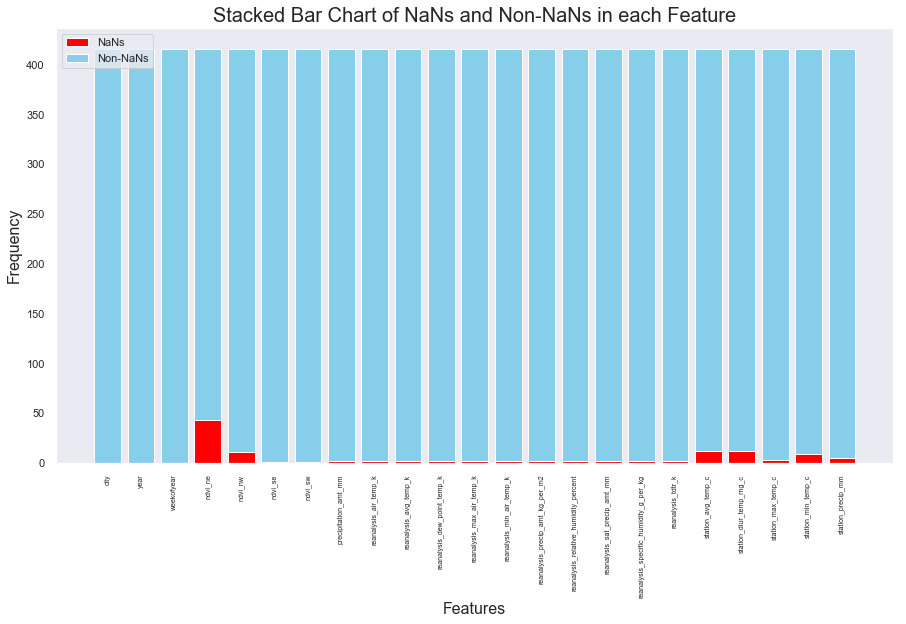

In [12]:
def feat_col_nans(df):
    '''
    FUNCTION: To display stacked bar chart of the NaNs vs Non-NaNs of each column in dataframe provided.
    
    Parameters
    ----------
    df: (pandas.DataFrame) Dataframe
    
    Returns
    -------
    Nothing. Displays the Stacked Bar chart
    '''
    # Get number of NaNs for each column
    nan_count_per_col = len(df) - df.count(axis=0)
    
    # Graph configs
    rcParams['figure.figsize'] = 15, 8
    sns.set()
    
    # Create NaNs
    plt.bar(np.arange(len(df.columns)), nan_count_per_col, color='red', edgecolor='white', label='NaNs')
    
    # Create Non-NaNs
    plt.bar(np.arange(len(df.columns)), df.count(), bottom=nan_count_per_col, color='skyblue', edgecolor='white', label='Non-NaNs')
    
    plt.title('Stacked Bar Chart of NaNs and Non-NaNs in each Feature', fontsize=20)
    plt.ylabel('Frequency', fontsize=16)
    plt.xlabel('Features', fontsize=16)
    plt.xticks(np.arange(len(df.columns)), df.columns, rotation=90, fontsize=7)
    plt.grid()
    plt.legend(loc='upper left');
    
feat_col_nans(test_feats_df)

In [13]:
# Taking care of missing data
test_feats_df.fillna(test_feats_df.mode().iloc[0], inplace=True)

# Drop unecessary feature columns
test_feats_df = test_feats_df.drop(['year', 'weekofyear'], axis=1)

# Split dataset to City sj and City iq
test_sj_X = test_feats_df[test_feats_df['city'] == 'sj'].drop(['city'], axis=1)
test_sj_X.index = pd.to_datetime(test_sj_X.index)

test_iq_X = test_feats_df[test_feats_df['city'] == 'iq'].drop(['city'], axis=1)
test_iq_X.index = pd.to_datetime(test_iq_X.index)

### Prediction

In [14]:
test_sj_y_pred = sj_pwr.inverse_transform(sj_trained_mods['AdaBoostRegressor'].predict(test_sj_X)[:,None])
test_iq_y_pred = iq_pwr.inverse_transform(iq_trained_mods['AdaBoostRegressor'].predict(test_iq_X)[:,None])

In [15]:
# Save the results to csv and upload to competition
submission_df = pd.read_csv('./data/dengai/submission_format.csv')
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [16]:
sj_submission_df = submission_df[submission_df['city'] == 'sj'].drop(['total_cases'], axis=1)
sj_submission_df.reset_index(inplace=True)
sj_submission_df = pd.concat([sj_submission_df, pd.DataFrame(test_sj_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
sj_submission_df.index = sj_submission_df['index']
sj_submission_df.drop(['index'], axis=1, inplace=True)
sj_submission_df.head()

,city,year,weekofyear,total_cases
index,,,,
0,sj,2008,18,6
1,sj,2008,19,8
2,sj,2008,20,9
3,sj,2008,21,11
4,sj,2008,22,12


In [17]:
iq_submission_df = submission_df[submission_df['city'] == 'iq'].drop(['total_cases'], axis=1)
iq_submission_df.reset_index(inplace=True)
iq_submission_df = pd.concat([iq_submission_df, pd.DataFrame(test_iq_y_pred.flatten().astype(int), columns=['total_cases'])], axis=1)
iq_submission_df.index = iq_submission_df['index']
iq_submission_df.drop(['index'], axis=1, inplace=True)
iq_submission_df.head()

,city,year,weekofyear,total_cases
index,,,,
260,iq,2010,26,5
261,iq,2010,27,1
262,iq,2010,28,5
263,iq,2010,29,2
264,iq,2010,30,1


In [18]:
submission_df = pd.concat([sj_submission_df, iq_submission_df], axis=0).reset_index().drop(['index'], axis=1)
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,8
2,sj,2008,20,9
3,sj,2008,21,11
4,sj,2008,22,12


In [19]:
# Save to csv
submission_df.to_csv('./data/dengai/adaboost_submission.csv', index=False)

__This received an MAE score of 29.2428 in the competition, which is pretty bad...__